In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [59]:
funding = pd.read_csv(
    r"D:\Homework\QF634\project\Data\raw_funding_rate\BNBUSDT_funding_rate_20200101_20251130.csv",
    parse_dates=["fundingDateTime"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f"),
)
funding = funding.sort_values("fundingDateTime")
funding = funding.rename(columns={"fundingDateTime": "timestamp", "fundingRate": "funding_rate"})
funding = funding.drop(columns=["symbol", "formattedFundingDateTime","markPrice"])
funding.set_index("timestamp", inplace=True)

spot = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\BNBUSDT_5m_binance_spot_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

future = pd.read_json(
    r"D:\Homework\QF634\project\Data\raw_historical_price\BNBUSDT_5m_binance_futures_historical_data.json",
    lines=True,
).sort_values("timestamp").set_index("timestamp")

spot.index = pd.to_datetime(spot.index)
future.index = pd.to_datetime(future.index)
funding.index = pd.to_datetime(funding.index)

#Remove data from 15 mins before funding rate

fund_times = funding.index.sort_values()

clean_spot_windows = {}
clean_future_windows = {}

for i in range(1, len(fund_times)):
    t_prev = fund_times[i - 1]
    t_curr = fund_times[i]

    window_start = t_prev
    window_end = t_curr - pd.Timedelta(minutes=15)  # remove final 15m

    spot_window = spot.loc[(spot.index >= window_start) & (spot.index < window_end)]
    fut_window = future.loc[(future.index >= window_start) & (future.index < window_end)]

    clean_spot_windows[t_curr] = spot_window
    clean_future_windows[t_curr] = fut_window

C:\Users\timkf\AppData\Local\Temp\ipykernel_36956\668347794.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  funding = pd.read_csv(


In [118]:
#Feature Engineering

spot_rows = []
future_rows = []

for t in fund_times[1:]:  # skip first because no full window
    sw = clean_spot_windows[t]
    fw = clean_future_windows[t]

    # ---- Spot ----
    spot_rows.append(pd.Series({
        "spot_open": sw["open"].iloc[0] if len(sw) else np.nan,
        "spot_high": sw["high"].max() if len(sw) else np.nan,
        "spot_low": sw["low"].min() if len(sw) else np.nan,
        "spot_close": sw["close"].iloc[-1] if len(sw) else np.nan,
        "spot_volume": sw["volume"].sum() if len(sw) else 0.0,
        "spot_quote_volume": sw["quote_asset_volume"].sum() if len(sw) else 0.0,
        "spot_trades": sw["number_of_trades"].sum() if len(sw) else 0.0,
        "spot_taker_buy_base": sw["taker_buy_base_asset_volume"].sum() if len(sw) else 0.0,
        "spot_taker_buy_quote": sw["taker_buy_quote_asset_volume"].sum() if len(sw) else 0.0,
    }, name=t))

    # ---- Future ----
    future_rows.append(pd.Series({
        "fut_open": fw["open"].iloc[0] if len(fw) else np.nan,
        "fut_high": fw["high"].max() if len(fw) else np.nan,
        "fut_low": fw["low"].min() if len(fw) else np.nan,
        "fut_close": fw["close"].iloc[-1] if len(fw) else np.nan,
        "fut_volume": fw["volume"].sum() if len(fw) else 0.0,
        "fut_quote_volume": fw["quote_asset_volume"].sum() if len(fw) else 0.0,
        "fut_trades": fw["number_of_trades"].sum() if len(fw) else 0.0,
        "fut_taker_buy_base": fw["taker_buy_base_asset_volume"].sum() if len(fw) else 0.0,
        "fut_taker_buy_quote": fw["taker_buy_quote_asset_volume"].sum() if len(fw) else 0.0,
    }, name=t))

spot_8h = pd.DataFrame(spot_rows)
future_8h = pd.DataFrame(future_rows)

# ==========================================================
# 5. MERGE ALL 4H DATA
# ==========================================================
df = funding.merge(spot_8h, left_index=True, right_index=True, how="left") \
            .merge(future_8h, left_index=True, right_index=True, how="left")

# ----------------------------------------------------------
# ASSUME df has: 
# - funding_rate column
# - is_spike column (from classifier labeling)
# - all engineered features used for classifier
# ----------------------------------------------------------

FUNDING_COL = "funding_rate"   # change as needed

df = df.sort_index().copy()
df = df.dropna(subset=[FUNDING_COL])

# ======================================================
# 1. FUNDING LAG FEATURES
# ======================================================
lags = [1, 2, 3, 6, 12]   # 1 lag = 4 hours, 6 = 1 day, 12 = 2 days

for L in lags:
    df[f"funding_lag_{L}"] = df[FUNDING_COL].shift(L)

# ======================================================
# 2. FUNDING ROLLING WINDOWS (4h * N)
# ======================================================
df["funding_vol_3"] = df[FUNDING_COL].rolling(3, closed='left').std()
df["funding_vol_6"] = df[FUNDING_COL].rolling(6,closed='left').std()
df["funding_vol_12"] = df[FUNDING_COL].rolling(12, closed='left').std()

def rolling_max_drawdown_safe(series, window):
    s = series.shift(1)  # exclude current
    roll = s.rolling(window)
    return (roll.max() - s) / roll.max()

df["funding_mdd_6"]  = rolling_max_drawdown_safe(df[FUNDING_COL], 6).fillna(0)
df["funding_mdd_12"] = rolling_max_drawdown_safe(df[FUNDING_COL], 12).fillna(0)

# df["funding_mdd_6"] = mdd.fillna(0)
# ======================================================
# 3. BASIS FEATURES (future - spot)
# ======================================================
df["basis"] = df["fut_close"] - df["spot_close"]
df["basis_change"] = df["basis"] - df["basis"].shift(1)
df["basis_lag_1"] = df["basis"].shift(1)
df["basis_lag_3"] = df["basis"].shift(3)

# ======================================================
# 4. PRICE MOMENTUM (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_ret_1"] = df[c].pct_change(1)
    df[f"{c}_ret_3"] = df[c].pct_change(3)
    df[f"{c}_ret_6"] = df[c].pct_change(6)

# ======================================================
# 5. PRICE VOLATILITY (spot + future)
# ======================================================
for c in ["spot_close", "fut_close"]:
    df[f"{c}_vol_3"] = df[c].pct_change().rolling(3).std()
    df[f"{c}_vol_6"] = df[c].pct_change().rolling(6).std()

# ======================================================
# 6. VOLUME PRESSURE FEATURES
# ======================================================
df["spot_buy_ratio"] = df["spot_taker_buy_base"] / (df["spot_volume"] + 1e-9)
df["fut_buy_ratio"]  = df["fut_taker_buy_base"] / (df["fut_volume"] + 1e-9)

df["spot_buy_ratio_lag1"] = df["spot_buy_ratio"].shift(1)
df["fut_buy_ratio_lag1"]  = df["fut_buy_ratio"].shift(1)

# ======================================================
# REMOVE ROWS WITH NAN FROM LAGS
# ======================================================
# df_prepared_features = df.dropna()
df_prepared_features = df

In [119]:
#only predict spike

TARGET_COL = "funding_rate"   # change if needed

# Compute 90th percentile threshold on the FULL dataset (before train/test split)
p90 = df_prepared_features[TARGET_COL].quantile(0.80)

print(f"90th percentile funding rate threshold: {p90:.8f}")

# Option 1: keep only large POSITIVE funding rates
df_p90 = df[df[TARGET_COL] >= p90].copy()

# Option 2 (alternative): keep extreme magnitude regardless of sign
# p90_abs = df[TARGET_COL].abs().quantile(0.90)
# df_p90 = df[df[TARGET_COL].abs() >= p90_abs].copy()

print(f"Rows before filtering: {len(df)}")
print(f"Rows after filtering : {len(df_p90)}")

# (Recommended) Drop NaNs caused by lag/rolling features AFTER filtering
FEATURES = [
    "spot_open","spot_high","spot_low","spot_close","spot_volume","spot_quote_volume",
    "spot_trades","spot_taker_buy_base","spot_taker_buy_quote",
    "fut_open","fut_high","fut_low","fut_close","fut_volume","fut_quote_volume",
    "fut_trades","fut_taker_buy_base","fut_taker_buy_quote",
    "funding_lag_1","funding_lag_2","funding_lag_3","funding_lag_6","funding_lag_12",
    "funding_vol_3","funding_vol_6","funding_vol_12",
    "funding_mdd_6","funding_mdd_12",
    "basis","basis_change","basis_lag_1","basis_lag_3",
    "spot_close_ret_1","spot_close_ret_3","spot_close_ret_6",
    "fut_close_ret_1","fut_close_ret_3","fut_close_ret_6",
    "spot_close_vol_3","spot_close_vol_6","fut_close_vol_3","fut_close_vol_6",
    "spot_buy_ratio","fut_buy_ratio","spot_buy_ratio_lag1","fut_buy_ratio_lag1"
]

df_p90 = df_p90[FEATURES + [TARGET_COL]].dropna()

print(f"Rows after dropna   : {len(df_p90)}")

90th percentile funding rate threshold: 0.00005826
Rows before filtering: 6360
Rows after filtering : 1272
Rows after dropna   : 1262


In [120]:
features = [c for c in df.columns 
            if c not in ["timestamp","markPrice", FUNDING_COL]]

df = df_p90.sort_values("timestamp")

X = df[FEATURES]
y = df[TARGET_COL].astype(float)
# Determine split index
split_ratio = 0.7
split_index = int(len(df) * split_ratio)

# Time-based train-test split
train = df.iloc[:split_index]
test  = df.iloc[split_index:]

X_train = train[features]
y_train = train[FUNDING_COL]

X_test = test[features]
y_test = test[FUNDING_COL]

print(features)

['spot_open', 'spot_high', 'spot_low', 'spot_close', 'spot_volume', 'spot_quote_volume', 'spot_trades', 'spot_taker_buy_base', 'spot_taker_buy_quote', 'fut_open', 'fut_high', 'fut_low', 'fut_close', 'fut_volume', 'fut_quote_volume', 'fut_trades', 'fut_taker_buy_base', 'fut_taker_buy_quote', 'funding_lag_1', 'funding_lag_2', 'funding_lag_3', 'funding_lag_6', 'funding_lag_12', 'funding_vol_3', 'funding_vol_6', 'funding_vol_12', 'funding_mdd_6', 'funding_mdd_12', 'basis', 'basis_change', 'basis_lag_1', 'basis_lag_3', 'spot_close_ret_1', 'spot_close_ret_3', 'spot_close_ret_6', 'fut_close_ret_1', 'fut_close_ret_3', 'fut_close_ret_6', 'spot_close_vol_3', 'spot_close_vol_6', 'fut_close_vol_3', 'fut_close_vol_6', 'spot_buy_ratio', 'fut_buy_ratio', 'spot_buy_ratio_lag1', 'fut_buy_ratio_lag1']


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

# -----------------------------
# Quantile model
# -----------------------------
def train_quantile_model(X, y, quantile):
    model = lgb.LGBMRegressor(
        objective="quantile",
        alpha=quantile,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X, y)
    return model


QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]

# -----------------------------
# OOF predictions (time series)
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)
oof_preds = {q: np.full(len(X_train), np.nan) for q in QUANTILES}

for q in QUANTILES:
    print(f"Generating OOF predictions for q={q}")
    
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]

        model = train_quantile_model(X_tr, y_tr, q)
        oof_preds[q][val_idx] = model.predict(X_val)

# Drop early rows without OOF predictions
X_meta_train = pd.DataFrame(oof_preds, index=X_train.index).dropna()
y_meta_train = y_train.loc[X_meta_train.index]

# -----------------------------
# Meta features (TRAIN)
# -----------------------------
meta_train = X_meta_train.copy()

meta_train["spread_90_50"] = meta_train[0.9] - meta_train[0.5]
meta_train["spread_95_90"] = meta_train[0.95] - meta_train[0.9]
meta_train["iqr"] = meta_train[0.7] - meta_train[0.3]

meta_train["tail_skew"] = (
    (meta_train[0.9] - meta_train[0.5]) /
    (meta_train[0.5].abs() + 1e-6)
)

META_REGIME_FEATURES = [
    "funding_lag_1",
    "funding_lag_3",
    "funding_vol_6",
    "funding_mdd_12",
    "basis",
    "basis_change",
    "spot_close_vol_6",
    "fut_close_ret_3",
]

meta_train = meta_train.join(
    X_train.loc[meta_train.index, META_REGIME_FEATURES]
)

# -----------------------------
# Train meta model
# -----------------------------
meta_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.02,
    depth=6,                 # ~ log2(64 leaves)
    subsample=0.9,
    rsm=0.9,                 # feature subsample (colsample_bytree)
    loss_function="Quantile:alpha=0.8",
    random_seed=42,
    verbose=False
)

y_meta = np.log1p(y_meta_train.values)

meta_model.fit(meta_train, y_meta)

# -----------------------------
# Refit quantile models on full train
# -----------------------------
quantile_models = {}
for q in QUANTILES:
    print(f"Training final quantile model q={q}")
    quantile_models[q] = train_quantile_model(X_train, y_train, q)

# -----------------------------
# Meta features (TEST)
# -----------------------------
X_meta_test = pd.DataFrame(
    {q: model.predict(X_test) for q, model in quantile_models.items()},
    index=X_test.index
)

meta_test = X_meta_test.copy()

meta_test["spread_90_50"] = meta_test[0.9] - meta_test[0.5]
meta_test["spread_95_90"] = meta_test[0.95] - meta_test[0.9]
meta_test["iqr"] = meta_test[0.7] - meta_test[0.3]

meta_test["tail_skew"] = (
    (meta_test[0.9] - meta_test[0.5]) /
    (meta_test[0.5].abs() + 1e-6)
)

meta_test = meta_test.join(
    X_test.loc[meta_test.index, META_REGIME_FEATURES]
)


# -----------------------------
# Final prediction
# -----------------------------
y_test_pred = np.expm1(meta_model.predict(meta_test))

final_pred_df = meta_test.copy()
final_pred_df["y_pred"] = y_test_pred
final_pred_df["y_true"] = y_test

print(final_pred_df.head())

Generating OOF predictions for q=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 46
[LightGBM] [Info] Start training from score 0.000124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [122]:
for q, model in quantile_models.items():
    final_pred_df[q] = model.predict(X_test)

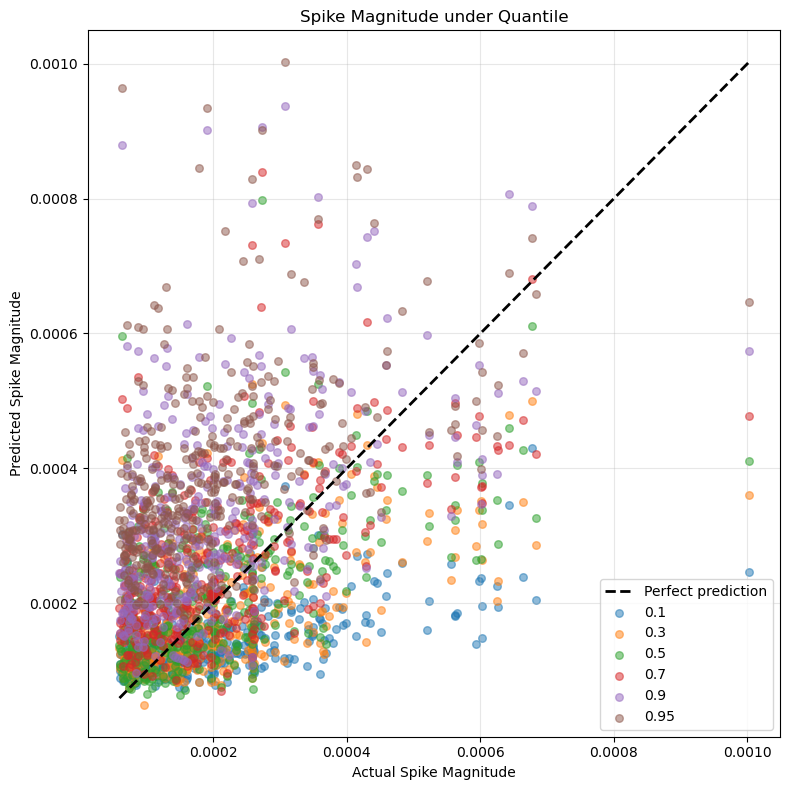

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = final_pred_df["y_true"].min()
max_y = final_pred_df["y_true"].max()

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

#QUANTILES = [0.5, 0.75, 0.9, 0.95]
columns = QUANTILES

# Plot each quantile
for q in columns:
    plt.scatter(
        final_pred_df["y_true"],
        final_pred_df[q],
        alpha=0.5,
        s=30,
        label=q
    )

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Predicted Spike Magnitude")
plt.title("Spike Magnitude under Quantile")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

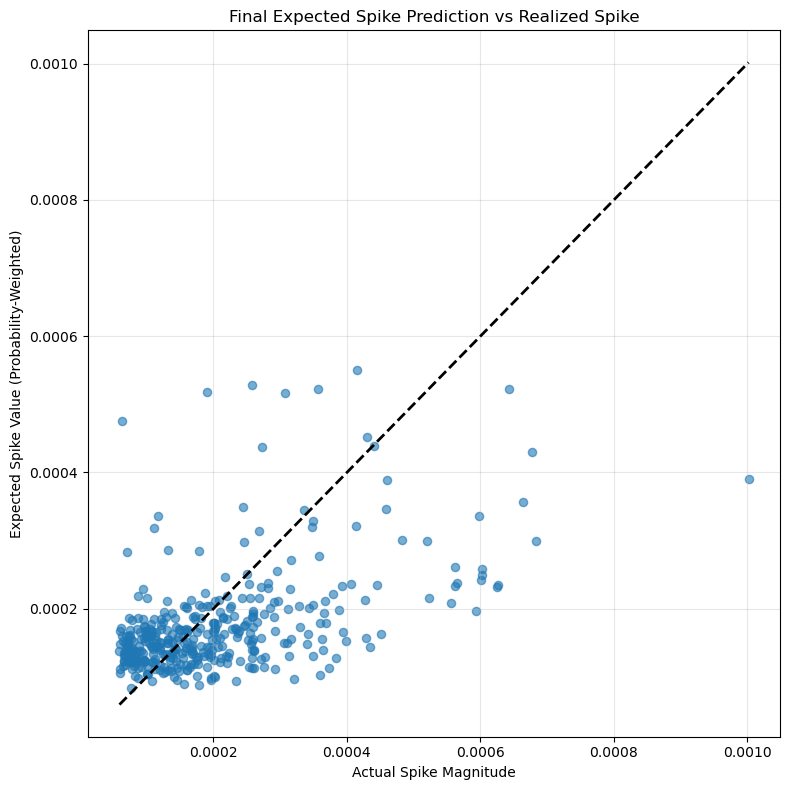

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = min(
    final_pred_df["y_pred"].min(),
    final_pred_df["y_true"].min()
)
max_y = max(
    final_pred_df["y_pred"].max(),
    final_pred_df["y_true"].max()
)

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

# Scatter plot
plt.scatter(
    final_pred_df["y_true"],
    final_pred_df["y_pred"],
    alpha=0.6,
    s=35
)

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Expected Spike Value (Probability-Weighted)")
plt.title("Final Expected Spike Prediction vs Realized Spike")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

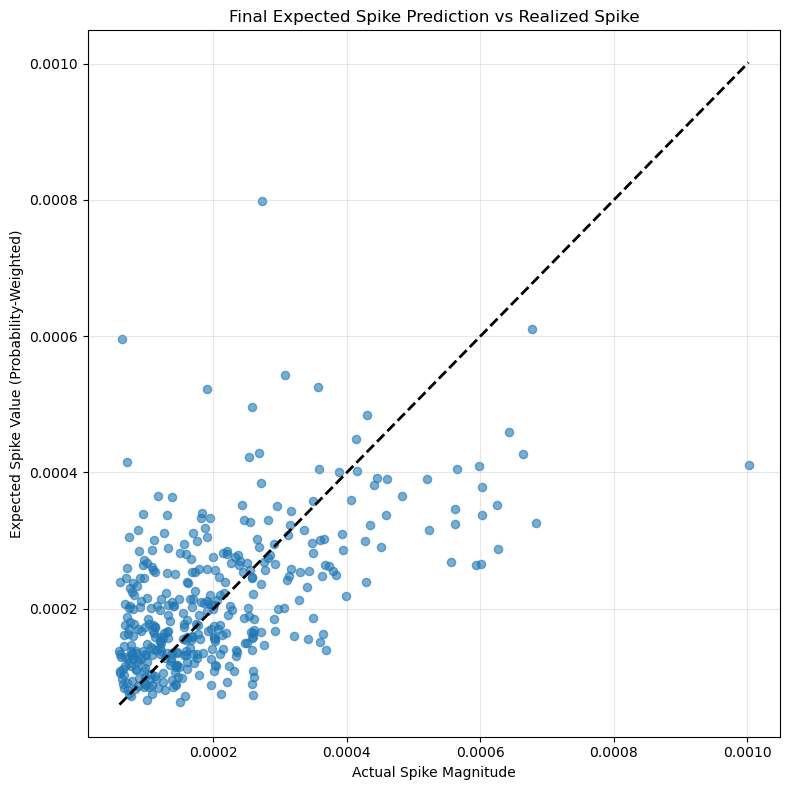

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Reference diagonal
min_y = min(
    final_pred_df[0.5].min(),
    final_pred_df["y_true"].min()
)
max_y = max(
    final_pred_df[0.5].max(),
    final_pred_df["y_true"].max()
)

plt.plot(
    [min_y, max_y],
    [min_y, max_y],
    linestyle="--",
    linewidth=2,
    color="black",
    label="Perfect prediction"
)

# Scatter plot
plt.scatter(
    final_pred_df["y_true"],
    final_pred_df[0.5],
    alpha=0.6,
    s=35
)

plt.xlabel("Actual Spike Magnitude")
plt.ylabel("Expected Spike Value (Probability-Weighted)")
plt.title("Final Expected Spike Prediction vs Realized Spike")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [128]:
mae = mean_absolute_error(final_pred_df["y_true"], final_pred_df["y_pred"])
print("MAE:", mae)
mae = mean_absolute_error(final_pred_df["y_true"], final_pred_df[0.5])
print("MAE:", mae)

MAE: 8.312153341586266e-05
MAE: 8.33328627096226e-05
